In [2]:
!pip install -U hopsworks --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 631.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 4.8 MB/s eta 0:00:00
  Preparing metad

In [23]:
    import hopsworks
    import pandas as pd
    # from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    # from sklearn.linear_model import SGDClassifier
    # from sklearn.naive_bayes import BernoulliNB
    from sklearn.pipeline import Pipeline, make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib
    import os

In [4]:
import os

for k, v in os.environ.items():
    if "HOPS" in k:
        print(f'{k}={v}')

In [5]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated

Paste it here: ··········
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/189588
Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# The feature view is the input set of features for your model. The features can come from different feature groups.
# You can select features from different feature groups and join them together to create a feature view
# diabetes_fg = fs.get_feature_group(name="diabetes", version=1)
diabetes_fg = fs.get_feature_group(name="diabetes_gan", version=1)
query = diabetes_fg.select_all()
# feature_view = fs.get_or_create_feature_view(name="diabetes",
feature_view = fs.get_or_create_feature_view(name="diabetes_gan",
                                  version=1,
                                  description="Read from Diabetes dataset",
                                  labels=["diabetes"],
                                  query=query)

In [7]:
batch_data = feature_view.get_batch_data()
batch_data

Finished: Reading data from Hopsworks, using ArrowFlight (2.88s) 


,age,bmi,hba1c_level,blood_glucose_level
0,80.000000,29.530000,6.600000,260
1,14.000000,20.700000,4.000000,126
2,55.000000,29.170000,4.500000,200
3,40.000000,21.790000,8.200000,300
4,59.000000,25.380000,4.500000,160
...,...,...,...,...
153516,74.552641,26.188465,6.598358,156
153517,71.686583,27.205169,8.178123,160
153518,59.547355,21.057546,5.692103,160
153519,51.046712,28.051713,6.534649,197


In [8]:
diabetes_df = pd.DataFrame(diabetes_fg.read())
diabetes_df.describe()

Finished: Reading data from Hopsworks, using ArrowFlight (2.76s) 


,age,bmi,hba1c_level,blood_glucose_level,diabetes
count,153521.000000,153521.000000,153521.000000,153521.000000,153521.000000
mean,50.052206,29.326898,5.984060,173.716736,0.495339
std,22.141041,7.820200,1.093770,65.101326,0.499980
min,-4.041839,10.010000,3.500000,80.000000,0.000000
25%,34.000000,25.550000,5.700000,130.000000,0.000000
50%,55.000000,27.422807,6.096647,158.000000,0.000000
75%,68.279673,31.928251,6.508532,216.000000,1.000000
max,82.235070,95.690000,9.241805,313.000000,1.000000


In [9]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (2.74s) 


In [28]:
# from sklearn.svm import SVC

# pipe = make_pipeline(StandardScaler(), BernoulliNB())
# pipe = make_pipeline(StandardScaler(), SGDClassifier())
pipe = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))
# pipe = make_pipeline(StandardScaler(), SVC(gamma='auto'))
pipe.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [30]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = pipe.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [31]:
print(metrics)
# metrics

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     15492
           1       0.99      0.96      0.98     15213

    accuracy                           0.98     30705
   macro avg       0.98      0.98      0.98     30705
weighted avg       0.98      0.98      0.98     30705



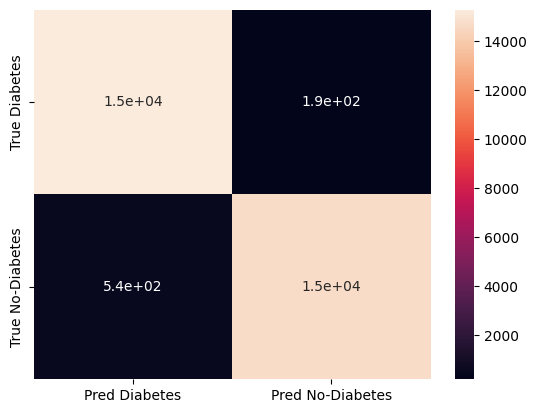

In [32]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['True Diabetes', 'True No-Diabetes'],
                     ['Pred Diabetes', 'Pred No-Diabetes'])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [ ]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="diabetes_gan_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(pipe, model_dir + "/diabetes_gan_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")


# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
diabetes_model = mr.python.create_model(
    name="diabetes_gan_model",
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Diabetes Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
diabetes_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/22323 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/50158911 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/468 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/189588/models/diabetes_gan_model/2


Model(name: 'diabetes_gan_model', version: 2)

In [ ]:
print(model_dir)

diabetes_gan_model
